In [5]:
# Para en google colab importar desde drive

# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# cd /content/drive/MyDrive/mask_datasets

In [8]:
import cv2, os
data_path ='C:/Users/mateo/Escritorio/python/projects/mask_detector/mask_datasets'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels))

print(label_dict)
print(categories)
print(labels)

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]


In [9]:
img_size=100
data=[]
target=[]

for category in categories:
  folder_path=os.path.join(data_path,category)
  img_names=os.listdir(folder_path)

  for img_name in img_names:
    img_path=os.path.join(folder_path,img_name)
    img=cv2.imread(img_path)

    try:
      gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
      resized=cv2.resize(gray,(img_size,img_size))
      data.append(resized)
      target.append(label_dict[category])
    except Exception as e:
      print('Exception:',e)

In [10]:
import numpy as np

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras import utils

new_target=utils.to_categorical(target)

In [11]:
new_target.shape

(1376, 2)

In [12]:
np.save('images.npy',data)
np.save('labels.npy',new_target)

In [13]:
import numpy as np

data=np.load('images.npy')
target=np.load('labels.npy')

In [14]:
data.shape

(1376, 100, 100, 1)

In [15]:
data.shape[1:]

(100, 100, 1)

In [16]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50,activation='relu'))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

c:\Users\mateo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 200)    │         2,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 98, 98, 200)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 200)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 100)    │       180,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 47, 47, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 52900)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 52900)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │     2,645,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,827,252 (10.79 MB)

 Trainable params: 2,827,252 (10.79 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,new_target,test_size=0.1)

In [19]:
train_data.shape

(1238, 100, 100, 1)

In [20]:
train_target.shape

(1238, 2)

In [21]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.keras',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=100,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 383ms/step - accuracy: 0.5291 - loss: 0.7891 - val_accuracy: 0.7177 - val_loss: 0.5851
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 366ms/step - accuracy: 0.7278 - loss: 0.5362 - val_accuracy: 0.8145 - val_loss: 0.4057
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 373ms/step - accuracy: 0.8497 - loss: 0.3356 - val_accuracy: 0.8306 - val_loss: 0.3668
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 371ms/step - accuracy: 0.9128 - loss: 0.2445 - val_accuracy: 0.8710 - val_loss: 0.3005
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.9116 - loss: 0.2280 - val_accuracy: 0.8992 - val_loss: 0.2470
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 361ms/step - accuracy: 0.9436 - loss: 0.1629 - val_accuracy: 0.8710 - val_loss: 0.4043
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.9294 - loss: 0.1817 - val_accuracy: 0.9153 - val_loss: 0.2645
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9644 - loss: 0.1063 - 

Reacalcar el uso del entorno de Ejecución, en mi caso CPU +120 segundos por vuelta, GPU T4 menos de 2 segundos por vuelta

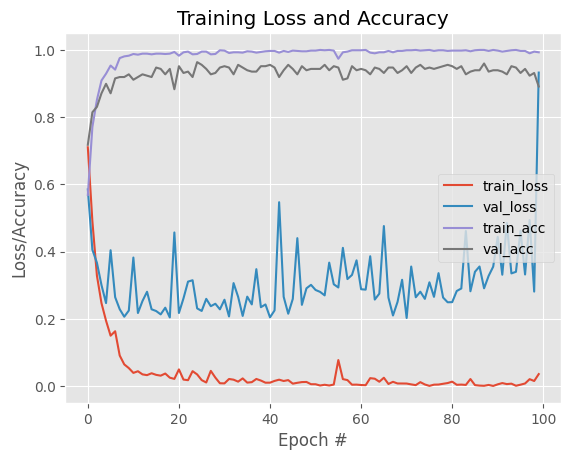

In [22]:
from matplotlib import pyplot as plt
N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("CNN_Model")